In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import random

In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

# Load dataset

In [3]:
file_path = '/kaggle/input/pm25-northern-vietnam'
df = pd.read_csv(file_path + '/train.csv', parse_dates=['time'])
print(len(df))
df.head()

8055


,time,ID,pm25,lat,lon,SQRT_SEA_DEM_LAT,WSPD,WDIR,TMP,TX,TN,TP,RH,PRES2M
0,2020-01-01,19,116.949130,21.049750,105.741870,5.922647,1.136119,145.942749,20.811243,23.219995,18.939997,0.3750,74.750000,102197.203125
1,2020-01-01,79,105.103043,21.015250,105.800130,4.307231,1.136119,145.942749,20.811243,23.219995,18.939997,0.3750,74.750000,102197.203125
2,2020-01-01,163,118.285100,21.024347,106.017288,4.988467,0.651509,145.395233,20.677492,23.029993,18.879999,0.1250,73.687500,102228.796875
3,2020-01-01,300,116.739130,21.023532,105.853941,4.865087,1.136119,145.942749,20.811243,23.219995,18.939997,0.3750,74.750000,102197.203125
4,2020-01-02,19,76.856667,21.049750,105.741870,5.922647,2.744283,147.084442,22.176249,25.119989,20.299982,0.1875,78.012497,102025.328125


In [4]:
df = df.sort_values(['ID', 'time']).reset_index(drop=True)
df.head()

,time,ID,pm25,lat,lon,SQRT_SEA_DEM_LAT,WSPD,WDIR,TMP,TX,TN,TP,RH,PRES2M
0,2020-02-26,5,54.661429,21.0213,105.8509,4.865087,3.055647,144.053604,22.779993,26.980005,19.119989,0.0000,71.849998,101519.875000
1,2020-02-29,5,25.771250,21.0213,105.8509,4.865087,4.075986,145.028137,23.912493,27.839991,21.299982,0.6250,75.724998,101098.835938
2,2020-03-01,5,28.635652,21.0213,105.8509,4.865087,3.050910,137.656815,24.142496,27.140009,21.619989,0.5000,78.075005,101089.875000
3,2020-03-02,5,21.906667,21.0213,105.8509,4.865087,4.523894,137.026627,24.297499,26.920008,22.879999,0.3750,75.512505,101164.203125
4,2020-03-03,5,13.835625,21.0213,105.8509,4.865087,4.421610,151.275787,24.263742,27.019983,22.529993,2.4375,76.137505,101179.117188


In [5]:
df_dev = pd.read_csv(file_path + '/dev.csv', parse_dates=['time'])
df_dev = df_dev.sort_values(['ID', 'time']).reset_index(drop=True)
df_dev.head()

,time,ID,pm25,lat,lon,SQRT_SEA_DEM_LAT,WSPD,WDIR,TMP,TX,TN,TP,RH,PRES2M
0,2021-05-11,19,22.132083,21.04975,105.74187,5.922647,3.800925,159.598328,30.950003,37.550011,25.749994,0.0000,68.562500,100172.304688
1,2021-05-12,19,19.387500,21.04975,105.74187,5.922647,3.296794,165.036392,30.725004,37.249992,26.450006,1.9375,70.900002,100213.265625
2,2021-05-13,19,27.319583,21.04975,105.74187,5.922647,3.155174,172.235855,29.850004,36.749992,25.350000,18.5000,76.275002,100239.085938
3,2021-05-14,19,27.685000,21.04975,105.74187,5.922647,4.464500,164.457855,29.812502,35.849998,25.350000,5.6250,73.537498,100224.226562
4,2021-05-15,19,22.887917,21.04975,105.74187,5.922647,5.185781,157.254791,30.662512,36.650017,26.650019,1.0000,72.699997,100247.953125


In [6]:
df_test = pd.read_csv(file_path + '/test.csv', parse_dates=['time'])
df_test = df_test.sort_values(['ID', 'time']).reset_index(drop=True)
df_test.head()

,time,ID,pm25,lat,lon,SQRT_SEA_DEM_LAT,WSPD,WDIR,TMP,TX,TN,TP,RH,PRES2M
0,2021-07-28,19,20.842500,21.04975,105.74187,5.922647,0.693913,339.214447,31.200006,35.349998,28.550013,5.6875,69.250000,99606.562500
1,2021-07-29,19,33.892500,21.04975,105.74187,5.922647,0.523525,185.343048,30.625010,35.450005,27.350000,4.5625,74.250000,99763.789062
2,2021-07-30,19,36.941667,21.04975,105.74187,5.922647,1.035424,239.131134,31.162508,35.749992,28.050013,1.9375,70.700005,99807.289062
3,2021-07-31,19,27.620833,21.04975,105.74187,5.922647,0.339110,285.829346,31.512503,36.550011,27.950006,2.6875,68.812500,99719.101562
4,2021-08-01,19,16.318571,21.04975,105.74187,5.922647,2.293170,297.920013,26.387503,27.950006,24.950006,16.7500,88.875000,99834.156250


In [7]:
def month_to_season(month):
    if month in [12, 1, 2]:
        return 0  # Winter
    elif month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    else:
        return 3  # Autumn

def add_season_features(dataframe):
    # Convert month to season
    dataframe['season'] = dataframe['time'].dt.month.apply(month_to_season)

    # Create one-hot encoding with all possible seasons
    all_seasons = [0, 1, 2, 3]  # Winter, Spring, Summer, Autumn
    for season in all_seasons:
        dataframe[f'season_{season}'] = (dataframe['season'] == season).astype(int)

    # Drop original season column
    dataframe.drop(columns=['season'], inplace=True)

    return dataframe

In [8]:
def engineering_features(df):
    df['time'] = pd.to_datetime(df['time'])
    df['month'] = df['time'].dt.month

    df = add_season_features(df)

    df['pm25_lag1'] = np.log1p(df['pm25'].shift(1))
    df['pm25_lag2'] = np.log1p(df['pm25'].shift(2))
    df['pm25_lag3'] = np.log1p(df['pm25'].shift(3))

    df['pm25_roll_mean_2'] = df["pm25"].shift(1).rolling(window=2).mean()
    df["pm25_roll_std_2"] = df["pm25"].shift(1).rolling(window=2).std()
    df["pm25_roll_mean_3"] = df["pm25"].shift(1).rolling(window=3).mean()
    df["pm25_roll_std_3"] = df["pm25"].shift(1).rolling(window=3).std()

    # 4. Xử lý NaN
    df = df.dropna().reset_index(drop=True)

    df['pm25'] = np.log1p(df['pm25'])

    return df

In [9]:
df = engineering_features(df)
df_dev = engineering_features(df_dev)
df_test = engineering_features(df_test)

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result 

In [10]:
df.head()

,time,ID,pm25,lat,lon,SQRT_SEA_DEM_LAT,WSPD,WDIR,TMP,TX,...,season_1,season_2,season_3,pm25_lag1,pm25_lag2,pm25_lag3,pm25_roll_mean_2,pm25_roll_std_2,pm25_roll_mean_3,pm25_roll_std_3
0,2020-03-02,5,3.131428,21.0213,105.8509,4.865087,4.523894,137.026627,24.297499,26.920008,...,1,0,0,3.388978,3.287329,4.019287,27.203451,2.025438,36.356110,15.917434
1,2020-03-03,5,2.697031,21.0213,105.8509,4.865087,4.421610,151.275787,24.263742,27.019983,...,1,0,0,3.131428,3.388978,3.287329,25.271159,4.758111,25.437856,3.376859
2,2020-03-04,5,2.890217,21.0213,105.8509,4.865087,3.464476,79.480682,20.423742,23.089991,...,1,0,0,2.697031,3.131428,3.388978,17.871146,5.707088,21.459315,7.410148
3,2020-03-07,5,3.372369,21.0213,105.8509,4.865087,2.818136,133.328522,23.942495,28.920008,...,1,0,0,2.890217,2.697031,3.131428,15.416424,2.235587,17.579838,4.066941
4,2020-03-08,5,3.653457,21.0213,105.8509,4.865087,1.927126,122.793274,26.831251,36.779991,...,1,0,0,3.372369,2.890217,2.697031,22.572361,7.884437,19.660116,7.518357


In [11]:
df_dev.head()

,time,ID,pm25,lat,lon,SQRT_SEA_DEM_LAT,WSPD,WDIR,TMP,TX,...,season_1,season_2,season_3,pm25_lag1,pm25_lag2,pm25_lag3,pm25_roll_mean_2,pm25_roll_std_2,pm25_roll_mean_3,pm25_roll_std_3
0,2021-05-14,19,3.356374,21.04975,105.74187,5.922647,4.464500,164.457855,29.812502,35.849998,...,1,0,0,3.343554,3.014922,3.141221,23.353542,5.608830,22.946389,4.028251
1,2021-05-15,19,3.173373,21.04975,105.74187,5.922647,5.185781,157.254791,30.662512,36.650017,...,1,0,0,3.356374,3.343554,3.014922,27.502292,0.258389,24.797361,4.688638
2,2021-05-16,19,3.182523,21.04975,105.74187,5.922647,3.752593,156.022003,30.675009,37.150017,...,1,0,0,3.173373,3.356374,3.343554,25.286458,3.392050,25.964167,2.670368
3,2021-05-17,19,3.033590,21.04975,105.74187,5.922647,4.172164,147.852692,29.337507,33.749992,...,1,0,0,3.182523,3.173373,3.356374,22.997708,0.155269,24.560139,2.708435
4,2021-05-18,19,3.099773,21.04975,105.74187,5.922647,4.497660,140.740845,29.110003,33.150017,...,1,0,0,3.033590,3.182523,3.173373,21.439583,2.358790,21.922361,1.865789


In [12]:
df_test.head()

,time,ID,pm25,lat,lon,SQRT_SEA_DEM_LAT,WSPD,WDIR,TMP,TX,...,season_1,season_2,season_3,pm25_lag1,pm25_lag2,pm25_lag3,pm25_roll_mean_2,pm25_roll_std_2,pm25_roll_mean_3,pm25_roll_std_3
0,2021-07-31,19,3.354135,21.04975,105.74187,5.922647,0.339110,285.829346,31.512503,36.550011,...,0,1,0,3.636050,3.552272,3.083858,35.417083,2.156086,30.558889,8.551638
1,2021-08-01,19,2.851779,21.04975,105.74187,5.922647,2.293170,297.920013,26.387503,27.950006,...,0,1,0,3.354135,3.636050,3.552272,32.281250,6.590824,32.818333,4.752353
2,2021-08-02,19,3.169826,21.04975,105.74187,5.922647,1.376523,294.633423,29.887506,36.150017,...,0,1,0,2.851779,3.354135,3.636050,21.969702,7.991906,26.960357,10.327400
3,2021-08-03,19,3.514772,21.04975,105.74187,5.922647,1.459764,311.250549,31.087507,37.150017,...,0,1,0,3.169826,2.851779,3.354135,19.560952,4.585419,22.247579,5.671590
4,2021-08-04,19,3.786413,21.04975,105.74187,5.922647,1.460672,320.834778,30.675005,36.749992,...,0,1,0,3.514772,3.169826,2.851779,27.705797,6.933131,23.910055,8.201044


# Compute correlation and create scenarios

In [13]:
def compute_correlation(df, target='pm25'):
    correlations = []
    for col in df.columns:
        if col not in ['index', 'time', 'ID', target]:
            corr = df[col].corr(df[target])
            correlations.append((col, corr))
    correlations.sort(key=lambda x: abs(x[1]), reverse=True)
    return correlations

In [14]:
correlations = compute_correlation(df)
for col, r in correlations:
    print(f'{col:20s} -> Pearson r = {r:.3f}')

pm25_lag1            -> Pearson r = 0.826
pm25_roll_mean_2     -> Pearson r = 0.689
pm25_lag2            -> Pearson r = 0.666
pm25_roll_mean_3     -> Pearson r = 0.660
pm25_lag3            -> Pearson r = 0.586
pm25_roll_std_3      -> Pearson r = 0.450
PRES2M               -> Pearson r = 0.399
pm25_roll_std_2      -> Pearson r = 0.388
season_0             -> Pearson r = 0.386
TN                   -> Pearson r = -0.347
TP                   -> Pearson r = -0.343
season_2             -> Pearson r = -0.303
TMP                  -> Pearson r = -0.295
WSPD                 -> Pearson r = -0.271
RH                   -> Pearson r = -0.259
TX                   -> Pearson r = -0.228
month                -> Pearson r = -0.221
lon                  -> Pearson r = -0.163
SQRT_SEA_DEM_LAT     -> Pearson r = 0.150
season_3             -> Pearson r = -0.148
lat                  -> Pearson r = -0.030
season_1             -> Pearson r = -0.017
WDIR                 -> Pearson r = 0.012


In [15]:
features_s1 = ['SQRT_SEA_DEM_LAT', 'WSPD', 'WDIR', 'TMP', 'TX', 'TN', 'TP', 'RH', 'PRES2M']
features_s2 = features_s1 + ['pm25_lag1', 'pm25_lag2', 'pm25_lag3']
features_s3 = features_s2 + ['month', 'season_0', 'season_1', 'season_2', 'season_3']
features_s4 = features_s3 + ['pm25_roll_mean_2', 'pm25_roll_mean_3', 'pm25_roll_std_2', 'pm25_roll_std_3']

# Create sequence for LSTM

In [16]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()

features = features_s2

target = 'pm25'

df[features] = scaler_X.fit_transform(df[features])
df[target] = scaler_y.fit_transform(df[[target]])

df.head()

,time,ID,pm25,lat,lon,SQRT_SEA_DEM_LAT,WSPD,WDIR,TMP,TX,...,season_1,season_2,season_3,pm25_lag1,pm25_lag2,pm25_lag3,pm25_roll_mean_2,pm25_roll_std_2,pm25_roll_mean_3,pm25_roll_std_3
0,2020-03-02,5,-0.427675,21.0213,105.8509,-0.7224,1.244798,0.179981,0.118810,-0.125881,...,1,0,0,-0.071064,-0.211729,0.801622,27.203451,2.025438,36.356110,15.917434
1,2020-03-03,5,-1.029161,21.0213,105.8509,-0.7224,1.166477,0.367215,0.112127,-0.109256,...,1,0,0,-0.427680,-0.070979,-0.211861,25.271159,4.758111,25.437856,3.376859
2,2020-03-04,5,-0.761667,21.0213,105.8509,-0.7224,0.433579,-0.576172,-0.648175,-0.762794,...,1,0,0,-1.029167,-0.427599,-0.071115,17.871146,5.707088,21.459315,7.410148
3,2020-03-07,5,-0.094057,21.0213,105.8509,-0.7224,-0.061338,0.131388,0.048521,0.206709,...,1,0,0,-0.761672,-1.029092,-0.427723,15.416424,2.235587,17.579838,4.066941
4,2020-03-08,5,0.295151,21.0213,105.8509,-0.7224,-0.743604,-0.007045,0.620481,1.513784,...,1,0,0,-0.094061,-0.761595,-1.029197,22.572361,7.884437,19.660116,7.518357


In [17]:
df_dev[features] = scaler_X.transform(df_dev[features])
df_dev[target] = scaler_y.transform(df_dev[[target]])

df_test.head()

,time,ID,pm25,lat,lon,SQRT_SEA_DEM_LAT,WSPD,WDIR,TMP,TX,...,season_1,season_2,season_3,pm25_lag1,pm25_lag2,pm25_lag3,pm25_roll_mean_2,pm25_roll_std_2,pm25_roll_mean_3,pm25_roll_std_3
0,2021-07-31,19,3.354135,21.04975,105.74187,5.922647,0.339110,285.829346,31.512503,36.550011,...,0,1,0,3.636050,3.552272,3.083858,35.417083,2.156086,30.558889,8.551638
1,2021-08-01,19,2.851779,21.04975,105.74187,5.922647,2.293170,297.920013,26.387503,27.950006,...,0,1,0,3.354135,3.636050,3.552272,32.281250,6.590824,32.818333,4.752353
2,2021-08-02,19,3.169826,21.04975,105.74187,5.922647,1.376523,294.633423,29.887506,36.150017,...,0,1,0,2.851779,3.354135,3.636050,21.969702,7.991906,26.960357,10.327400
3,2021-08-03,19,3.514772,21.04975,105.74187,5.922647,1.459764,311.250549,31.087507,37.150017,...,0,1,0,3.169826,2.851779,3.354135,19.560952,4.585419,22.247579,5.671590
4,2021-08-04,19,3.786413,21.04975,105.74187,5.922647,1.460672,320.834778,30.675005,36.749992,...,0,1,0,3.514772,3.169826,2.851779,27.705797,6.933131,23.910055,8.201044


In [18]:
df_test[features] = scaler_X.transform(df_test[features])
df_test[target] = scaler_y.transform(df_test[[target]])

df_test.head()

,time,ID,pm25,lat,lon,SQRT_SEA_DEM_LAT,WSPD,WDIR,TMP,TX,...,season_1,season_2,season_3,pm25_lag1,pm25_lag2,pm25_lag3,pm25_roll_mean_2,pm25_roll_std_2,pm25_roll_mean_3,pm25_roll_std_3
0,2021-07-31,19,-0.119305,21.04975,105.74187,0.975704,-1.959582,2.135248,1.547346,1.475540,...,0,1,0,0.271044,0.155129,-0.493590,35.417083,2.156086,30.558889,8.551638
1,2021-08-01,19,-0.814890,21.04975,105.74187,0.975704,-0.463316,2.294119,0.532621,0.045402,...,0,1,0,-0.119309,0.271133,0.154984,32.281250,6.590824,32.818333,4.752353
2,2021-08-02,19,-0.374508,21.04975,105.74187,0.975704,-1.165212,2.250933,1.225605,1.409023,...,0,1,0,-0.814895,-0.119225,0.270985,21.969702,7.991906,26.960357,10.327400
3,2021-08-03,19,0.103121,21.04975,105.74187,0.975704,-1.101472,2.469282,1.463199,1.575318,...,0,1,0,-0.374513,-0.814818,-0.119360,19.560952,4.585419,22.247579,5.671590
4,2021-08-04,19,0.479248,21.04975,105.74187,0.975704,-1.100777,2.595219,1.381526,1.508796,...,0,1,0,0.103116,-0.374431,-0.814930,27.705797,6.933131,23.910055,8.201044


In [19]:
from torch.utils.data import Dataset, DataLoader

class SequenceDataset(Dataset):
    def __init__(self, data, features, target='pm25', sequence_length=7, n_future=1):
        self.X = []
        self.y = []
        grouped = data.groupby('ID')

        for _, group in grouped:
            group = group.sort_values('time').reset_index(drop=True)
            values = group[features + [target]].values

            for i in range(sequence_length, len(values) - n_future + 1):
                self.X.append(values[i-sequence_length:i, :-1])
                self.y.append(values[i:i+n_future, -1])

        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Model construction

In [20]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, dropout, num_layers, n_future=1):
        super(LSTMModel, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0  # PyTorch chỉ apply dropout nếu num_layers > 1
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, n_future)
        )

    def forward(self, x):
        out, (h_n, c_n) = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyperparameters
n_future = 3
sequence_length = 3
batch_size = 32
hidden_size = 256
dropout = 0.1
num_layers = 2
epochs = 50
lr = 0.0005

data_train = SequenceDataset(df, features, target=target, sequence_length=sequence_length, n_future=n_future)
loader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)

data_dev = SequenceDataset(df_dev, features, target=target, sequence_length=sequence_length, n_future=n_future)
loader_dev = DataLoader(data_dev, batch_size=batch_size, shuffle=True)

data_test = SequenceDataset(df_test, features, target=target, sequence_length=sequence_length, n_future=n_future)
loader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

model = LSTMModel(input_size=len(features), hidden_size=hidden_size, dropout=dropout, num_layers=num_layers, n_future=n_future).to(device)

loss_fn = nn.HuberLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

/tmp/ipykernel_19/3180751654.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  self.X = torch.tensor(self.X, dtype=torch.float32)


In [22]:
from sklearn.metrics import r2_score

best_val_loss = float('inf')
patience = 5
counter = 0

for epoch in range(epochs):
    model.train()

    total_loss = 0

    for x_batch, y_batch in loader_train:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}: Loss = {total_loss/len(loader_train):.4f}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in loader_dev:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            val_loss += loss_fn(y_pred, y_batch).item()

    val_loss = val_loss/len(loader_dev)
    print(f"Validation Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

Epoch 1/50: Loss = 0.2596
Validation Loss: 0.1583
Epoch 2/50: Loss = 0.2046
Validation Loss: 0.1499
Epoch 3/50: Loss = 0.1950
Validation Loss: 0.1521
Epoch 4/50: Loss = 0.1881
Validation Loss: 0.1456
Epoch 5/50: Loss = 0.1820
Validation Loss: 0.1446
Epoch 6/50: Loss = 0.1761
Validation Loss: 0.1450
Epoch 7/50: Loss = 0.1713
Validation Loss: 0.1469
Epoch 8/50: Loss = 0.1676
Validation Loss: 0.1498
Epoch 9/50: Loss = 0.1624
Validation Loss: 0.1538
Epoch 10/50: Loss = 0.1590
Validation Loss: 0.1540
Early stopping


In [23]:
def calculate_ioa(obs, pred):
    numerator = np.sum((pred - obs) ** 2)
    denominator = np.sum((np.abs(pred - np.mean(obs)) + np.abs(obs - np.mean(obs))) ** 2)
    ioa = 1 - numerator / denominator
    return ioa

def calculate_nmb(obs, pred):
    nmb = np.sum(pred - obs) / np.sum(obs)
    return nmb

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

def evaluate(model, loader):
    model.eval()
    trues, preds = [], []
    with torch.no_grad():
        for Xb, yb in loader:
            out = model(Xb.to(device)).cpu().numpy()
            preds.append(out)
            trues.append(yb.numpy())
    y_true = np.vstack(trues)
    y_pred = np.vstack(preds)

    metrics = {}
    for k in range(n_future):
        # inverse transform per-trial scaler
        true_k = np.expm1(scaler_y.inverse_transform(y_true[:, k].reshape(-1,1)).flatten())
        pred_k = np.expm1(scaler_y.inverse_transform(y_pred[:, k].reshape(-1,1)).flatten())
        metrics_key = 't' if k == 0 else f't+{k}'
        metrics[metrics_key] = {
            'RMSE': float(np.sqrt(mean_squared_error(true_k, pred_k))),
            'MAE': float(mean_absolute_error(true_k, pred_k)),
            'R2': float(r2_score(true_k, pred_k)),
            'Pearson r': float(pearsonr(true_k, pred_k)[0]),
            'IOA': float(calculate_ioa(true_k, pred_k)),
            'NMB': float(calculate_nmb(true_k, pred_k))
        }
    return metrics, y_true, y_pred

In [25]:
import matplotlib.pyplot as plt

def plot_all_horizons(y_true, y_pred, title):
    fig, axes = plt.subplots(1, n_future, figsize=(5*n_future, 4))
    axes = np.atleast_1d(axes)
    for k, ax in enumerate(axes):
        true_k = np.expm1(scaler_y.inverse_transform(y_true[:, k].reshape(-1,1)).flatten())
        pred_k = np.expm1(scaler_y.inverse_transform(y_pred[:, k].reshape(-1,1)).flatten())
        ax.plot(true_k, label=f"True {'t' if k==0 else 't+'+str(k)}")
        ax.plot(pred_k, label=f"Pred {'t' if k==0 else 't+'+str(k)}")
        ax.set_title(f"{title} {'t' if k==0 else 't+'+str(k)}", fontsize=10)
        ax.set_xlabel("Days")
        ax.set_ylabel("PM2.5")
        ax.legend()
    plt.tight_layout()
    plt.show()

t: {'RMSE': 16.503854751586914, 'MAE': 10.297769546508789, 'R2': 0.7240658456210463, 'Pearson r': 0.8575084209442139, 'IOA': 0.9074811786413193, 'NMB': -0.05333033949136734}
t+1: {'RMSE': 17.819927215576172, 'MAE': 11.49356460571289, 'R2': 0.6781319982995172, 'Pearson r': 0.8273153305053711, 'IOA': 0.8916121125221252, 'NMB': -0.05060303583741188}
t+2: {'RMSE': 18.77153968811035, 'MAE': 12.308969497680664, 'R2': 0.6424805202154069, 'Pearson r': 0.8091216683387756, 'IOA': 0.8722661882638931, 'NMB': -0.062450528144836426}


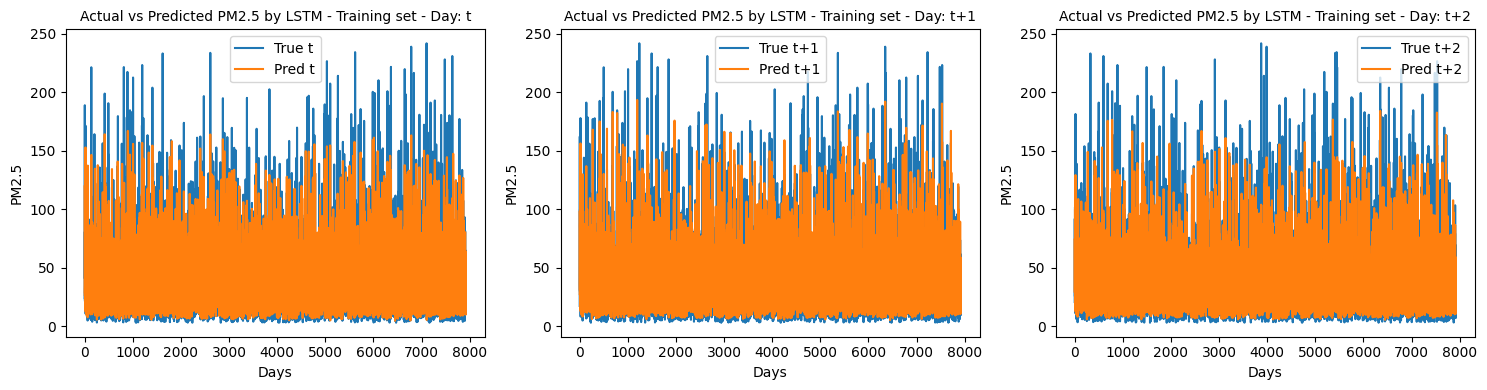

In [26]:
# train test
train_metrics, y_true, y_pred = evaluate(model, loader_train)
for k, v in train_metrics.items():
  print(f"{k}: {v}")
title = "Actual vs Predicted PM2.5 by LSTM - Training set - Day:"
plot_all_horizons(y_true, y_pred, title)

t: {'RMSE': 11.938138008117676, 'MAE': 7.345000743865967, 'R2': 0.4076394168352975, 'Pearson r': 0.647192656993866, 'IOA': 0.7219127118587494, 'NMB': -0.039985086768865585}
t+1: {'RMSE': 12.870436668395996, 'MAE': 7.637630939483643, 'R2': 0.3084405719397115, 'Pearson r': 0.5657204985618591, 'IOA': 0.6429078280925751, 'NMB': -0.05948921665549278}
t+2: {'RMSE': 12.8966646194458, 'MAE': 7.750274181365967, 'R2': 0.30290201497921965, 'Pearson r': 0.5648420453071594, 'IOA': 0.6357709765434265, 'NMB': -0.07028764486312866}


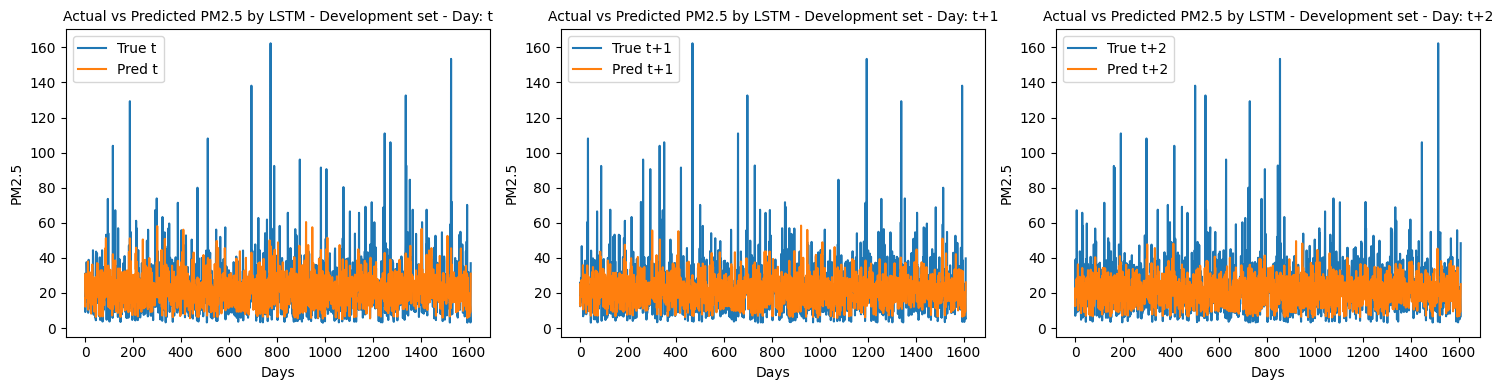

In [27]:
# dev test
dev_metrics, y_true, y_pred = evaluate(model, loader_dev)
for k, v in dev_metrics.items():
  print(f"{k}: {v}")
title = "Actual vs Predicted PM2.5 by LSTM - Development set - Day:"
plot_all_horizons(y_true, y_pred, title)

t: {'RMSE': 15.062202453613281, 'MAE': 10.09933853149414, 'R2': 0.6869193438949943, 'Pearson r': 0.833175539970398, 'IOA': 0.8912835940718651, 'NMB': -0.013209265656769276}
t+1: {'RMSE': 16.9964542388916, 'MAE': 11.299086570739746, 'R2': 0.6012646790371513, 'Pearson r': 0.7840361595153809, 'IOA': 0.8488263934850693, 'NMB': -0.05376941338181496}
t+2: {'RMSE': 18.622413635253906, 'MAE': 12.539923667907715, 'R2': 0.5222985484514614, 'Pearson r': 0.7355945110321045, 'IOA': 0.8057042211294174, 'NMB': -0.08241474628448486}


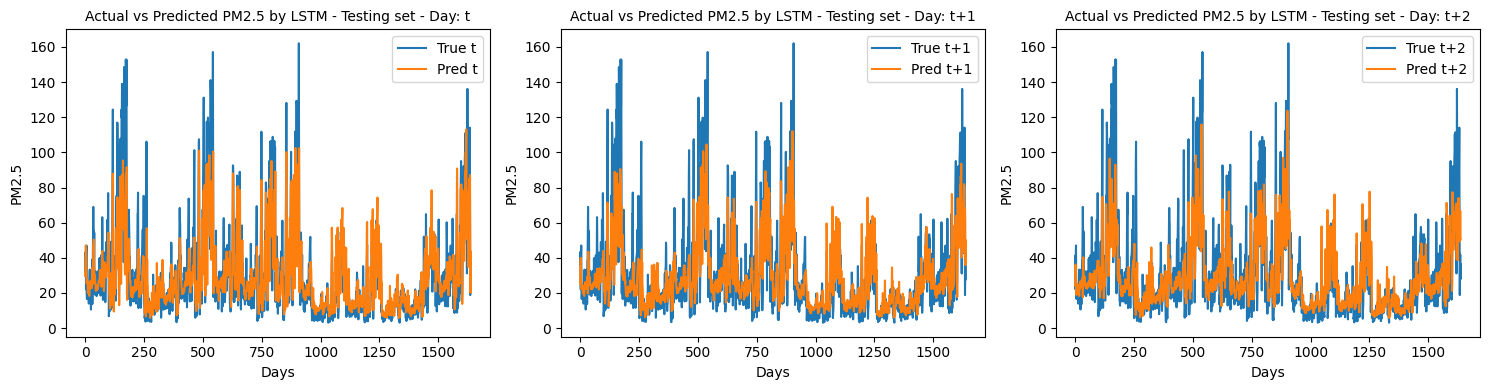

In [28]:
# test set
test_metrics, y_true, y_pred = evaluate(model, loader_test)
for k, v in test_metrics.items():
  print(f"{k}: {v}")
title = "Actual vs Predicted PM2.5 by LSTM - Testing set - Day:"
plot_all_horizons(y_true, y_pred, title)

t: {'RMSE': 15.062202453613281, 'MAE': 10.09933853149414, 'R2': 0.6869193438949943, 'Pearson r': 0.833175539970398, 'IOA': 0.8912835940718651, 'NMB': -0.013209265656769276}
t+1: {'RMSE': 16.9964542388916, 'MAE': 11.299086570739746, 'R2': 0.6012646790371513, 'Pearson r': 0.7840361595153809, 'IOA': 0.8488263934850693, 'NMB': -0.05376941338181496}
t+2: {'RMSE': 18.622413635253906, 'MAE': 12.539923667907715, 'R2': 0.5222985484514614, 'Pearson r': 0.7355945110321045, 'IOA': 0.8057042211294174, 'NMB': -0.08241474628448486}


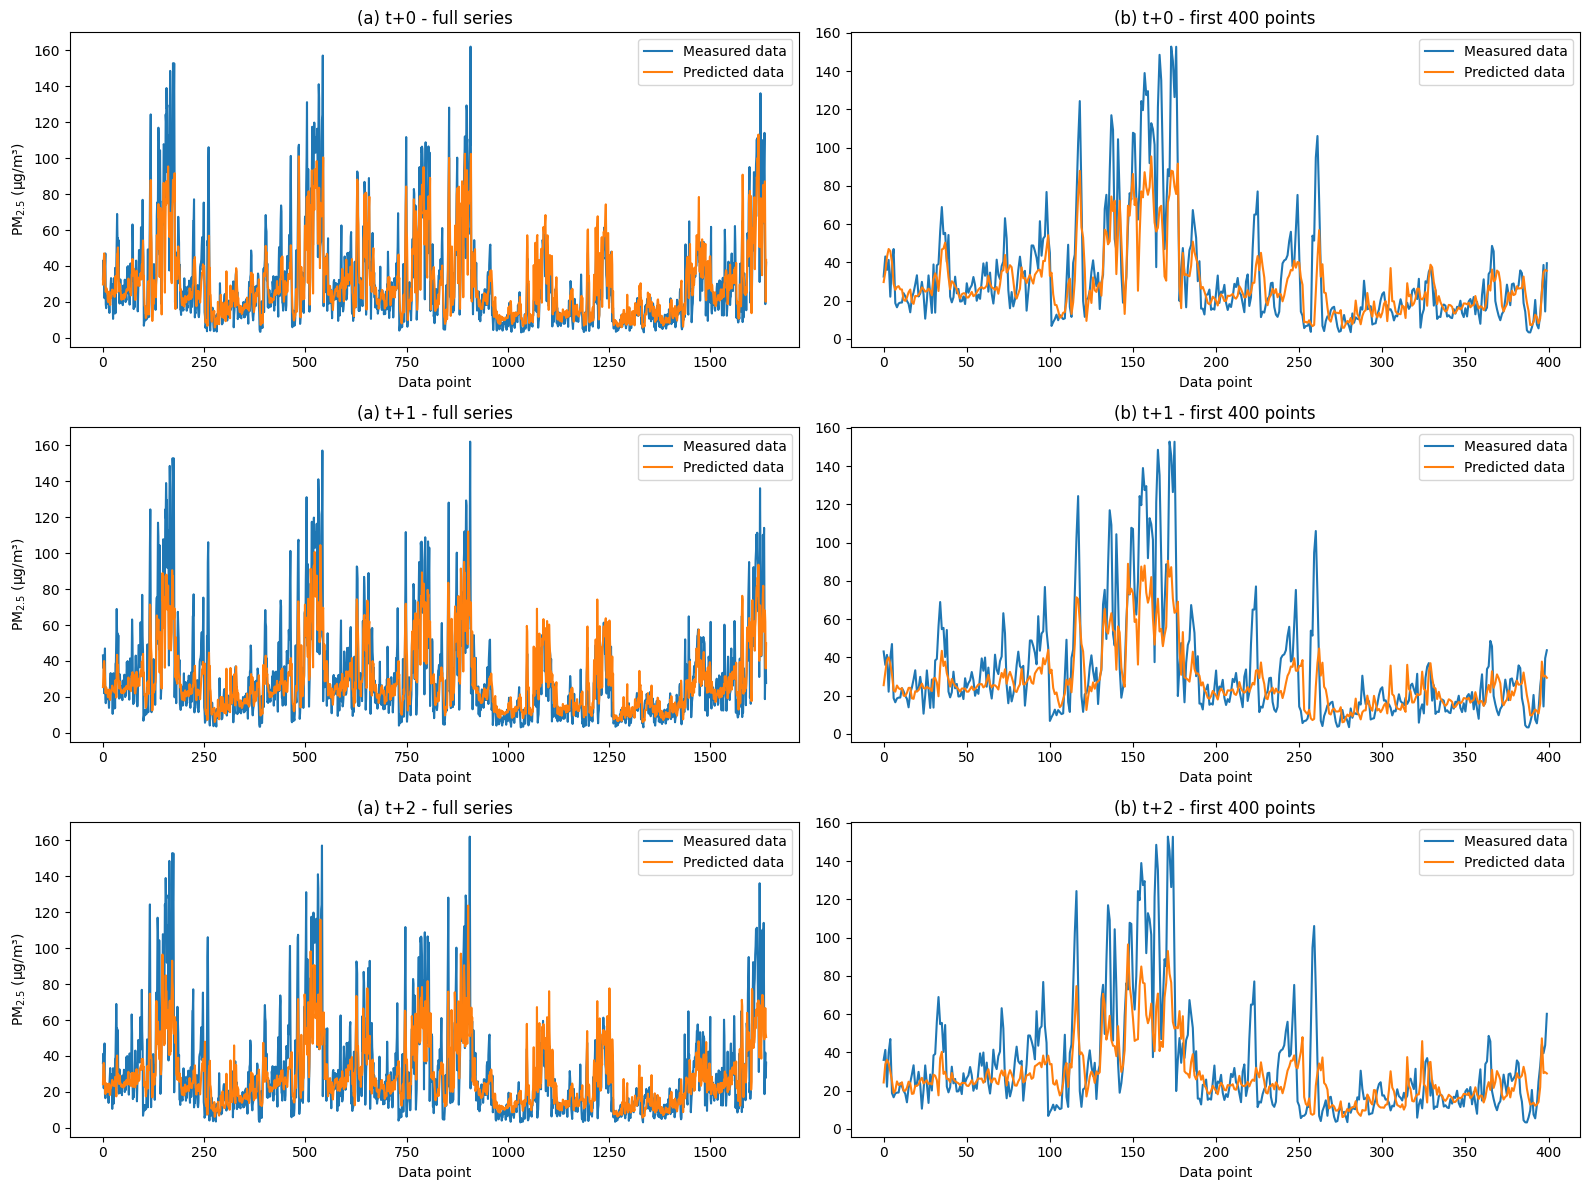

In [29]:
# test set
test_metrics, y_true, y_pred = evaluate(model, loader_test)
for k, v in test_metrics.items():
  print(f"{k}: {v}")

y_true_inv = np.expm1(scaler_y.inverse_transform(y_true))
y_pred_inv = np.expm1(scaler_y.inverse_transform(y_pred))

output_steps = y_true.shape[1]
num_points = y_true.shape[0]

fig, axs = plt.subplots(output_steps, 2, figsize=(16, 12))

for i in range(output_steps):
    axs[i, 0].plot(y_true_inv[:, i], label='Measured data')
    axs[i, 0].plot(y_pred_inv[:, i], label='Predicted data')
    axs[i, 0].set_title(f'(a) t+{i} - full series')
    axs[i, 0].set_ylabel('PM$_{2.5}$ (µg/m³)')
    axs[i, 0].set_xlabel('Data point')
    axs[i, 0].legend()

    axs[i, 1].plot(y_true_inv[:400, i], label='Measured data')
    axs[i, 1].plot(y_pred_inv[:400, i], label='Predicted data')
    axs[i, 1].set_title(f'(b) t+{i} - first 400 points')
    axs[i, 1].set_xlabel('Data point')
    axs[i, 1].legend()

plt.tight_layout()
plt.show()

In [30]:
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import r2_score

# Đặt random seed ổn định
def seed_everything(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [31]:
import optuna
import torch
import torch.nn as nn
from sklearn.metrics import r2_score

def objective(trial):
    # Sample hyperparameters
    hidden_size = trial.suggest_categorical("hidden_size", [64, 128, 256, 512])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    sequence_length = trial.suggest_categorical("sequence_length", [3, 5, 7, 10])

    # Prepare Dataloader (dùng sequence_length và batch_size mới)
    train_loader = DataLoader(SequenceDataset(df, features, target, sequence_length, n_future), batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(SequenceDataset(df_dev, features, target, sequence_length, n_future), batch_size=batch_size, shuffle=False)

    # Build model
    model = LSTMModel(input_size=len(features),
                        hidden_size=hidden_size,
                        num_layers=num_layers,
                        dropout=dropout,
                        n_future=n_future).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.HuberLoss()  # hoặc loss_fn bạn đang dùng

    patience = 5
    best_val_r2 = -float('inf')
    counter = 0

    for epoch in range(30):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            y_pred = model(xb)
            loss = criterion(y_pred, yb)
            loss.backward()
            optimizer.step()

        model.eval()
        y_true_list, y_pred_list = [], []
        with torch.no_grad():
            for xb, yb in dev_loader:
                xb, yb = xb.to(device), yb.to(device)
                y_pred = model(xb)
                y_true_list.append(yb.cpu())
                y_pred_list.append(y_pred.cpu())

        y_true_full = torch.cat(y_true_list).numpy()
        y_pred_full = torch.cat(y_pred_list).numpy()

        val_r2 = r2_score(y_true_full, y_pred_full)

        if val_r2 > best_val_r2:
            best_val_r2 = val_r2
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                break

    return best_val_r2


In [32]:
study = optuna.create_study(direction="maximize")  # maximize R2
study.optimize(objective, n_trials=100)  # thử 50 bộ tham số

print("Best trial:")
trial = study.best_trial

print(f"R²: {trial.value}")
print("Best hyperparameters:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-04-30 16:41:17,834] A new study created in memory with name: no-name-611b2757-9b8f-4e9f-8f61-97c955ce61ab
[I 2025-04-30 16:41:24,209] Trial 0 finished with value: 0.564450622295932 and parameters: {'hidden_size': 256, 'num_layers': 1, 'dropout': 0.42312584790442986, 'lr': 0.00010162514216543543, 'batch_size': 128, 'sequence_length': 5}. Best is trial 0 with value: 0.564450622295932.
[I 2025-04-30 16:41:37,219] Trial 1 finished with value: 0.4495175079052931 and parameters: {'hidden_size': 64, 'num_layers': 3, 'dropout': 0.06077848545494058, 'lr': 1.1110975695145006e-05, 'batch_size': 64, 'sequence_length': 5}. Best is trial 0 with value: 0.564450622295932.
[I 2025-04-30 16:41:57,263] Trial 2 finished with value: 0.5589257143513339 and parameters: {'hidden_size': 512, 'num_layers': 1, 'dropout': 0.2757270798715156, 'lr': 3.440249661584825e-05, 'batch_size': 32, 'sequence_length': 5}. Best is trial 0 with value: 0.564450622295932.
[I 2025-04-30 16:42:16,200] Trial 3 finished with

Best trial:
R²: 0.5894326141795455
Best hyperparameters:
    hidden_size: 512
    num_layers: 1
    dropout: 0.13290494396132854
    lr: 9.43985485280091e-05
    batch_size: 32
    sequence_length: 7


In [33]:
best_params = study.best_params

# Gộp train + dev
df_full = pd.concat([df, df_dev], ignore_index=True)

# Dataloader
train_full_dataset = SequenceDataset(df_full, features, target='pm25', sequence_length=best_params["sequence_length"], n_future=n_future)
train_full_loader = DataLoader(train_full_dataset, batch_size=best_params["batch_size"], shuffle=True)

# Model
model_final = LSTMModel(
    input_size=len(features),
    hidden_size=best_params["hidden_size"],
    dropout=best_params["dropout"],
    num_layers=best_params["num_layers"],
    n_future=n_future
).to(device)

optimizer_final = optim.Adam(model_final.parameters(), lr=best_params["lr"])
loss_fn_final = nn.HuberLoss()

In [34]:
# Train
epochs = 50
patience = 5  
best_val_loss = float('inf')
counter = 0

for epoch in range(epochs):
    model_final.train()
    total_loss = 0
    for xb, yb in loader_train:
        xb, yb = xb.to(device), yb.to(device)
        optimizer_final.zero_grad()
        pred = model_final(xb)
        loss = loss_fn_final(pred, yb)
        loss.backward()
        optimizer_final.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss/len(train_full_loader):.6f}")
    
    model_final.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in loader_dev:
            xb, yb = xb.to(device), yb.to(device)
            pred = model_final(xb)
            val_loss += loss_fn_final(pred, yb).item()
    val_loss /= len(loader_dev)
    print(f"Validation Loss: {val_loss:.6f}")

    # Kiểm tra điều kiện early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_final.state_dict(), 'best_model_final.pt')  # Lưu mô hình tốt nhất
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

Epoch [1/50] Loss: 0.247829
Validation Loss: 0.168514
Epoch [2/50] Loss: 0.194592
Validation Loss: 0.156492
Epoch [3/50] Loss: 0.183787
Validation Loss: 0.152691
Epoch [4/50] Loss: 0.174167
Validation Loss: 0.151860
Epoch [5/50] Loss: 0.167294
Validation Loss: 0.149369
Epoch [6/50] Loss: 0.163454
Validation Loss: 0.153659
Epoch [7/50] Loss: 0.160870
Validation Loss: 0.149759
Epoch [8/50] Loss: 0.157919
Validation Loss: 0.149083
Epoch [9/50] Loss: 0.157128
Validation Loss: 0.148372
Epoch [10/50] Loss: 0.154125
Validation Loss: 0.146489
Epoch [11/50] Loss: 0.152387
Validation Loss: 0.149118
Epoch [12/50] Loss: 0.151309
Validation Loss: 0.145952
Epoch [13/50] Loss: 0.150487
Validation Loss: 0.146577
Epoch [14/50] Loss: 0.149983
Validation Loss: 0.148888
Epoch [15/50] Loss: 0.147634
Validation Loss: 0.151630
Epoch [16/50] Loss: 0.147547
Validation Loss: 0.146819
Epoch [17/50] Loss: 0.145948
Validation Loss: 0.143206
Epoch [18/50] Loss: 0.144855
Validation Loss: 0.148761
Epoch [19/50] Loss:

Test metrics:
t: {'RMSE': 17.198169708251953, 'MAE': 10.881331443786621, 'R2': 0.7003604650535249, 'Pearson r': 0.8382055759429932, 'IOA': 0.904247373342514, 'NMB': -0.03709565848112106}
t+1: {'RMSE': 18.96030616760254, 'MAE': 12.282915115356445, 'R2': 0.6356182422633816, 'Pearson r': 0.8007828593254089, 'IOA': 0.8750055879354477, 'NMB': -0.05549624189734459}
t+2: {'RMSE': 20.00759506225586, 'MAE': 13.219891548156738, 'R2': 0.5938470040766932, 'Pearson r': 0.7744684219360352, 'IOA': 0.8591576814651489, 'NMB': -0.06181194260716438}


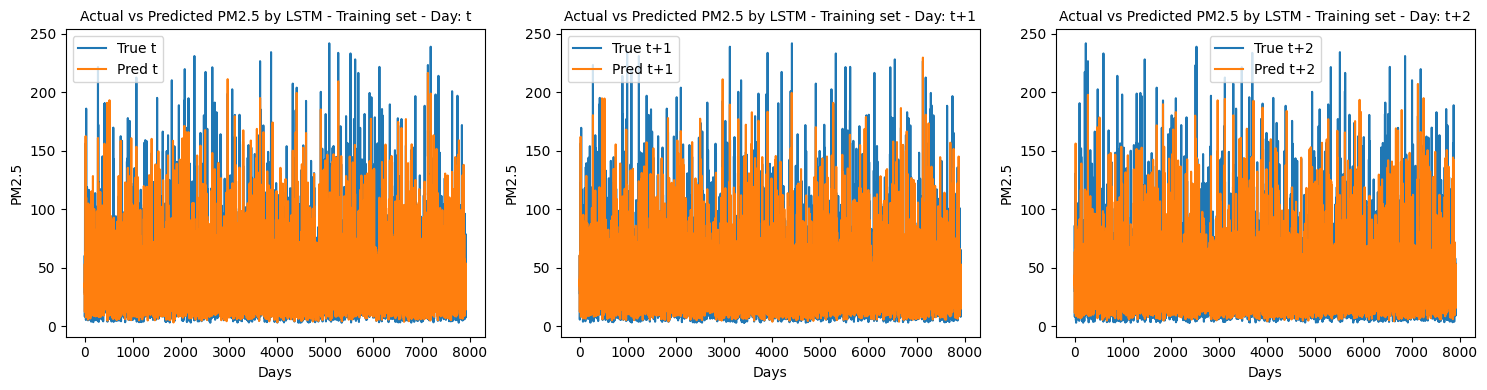

In [35]:
# train set
test_metrics, y_true, y_pred = evaluate(model_final, loader_train)
print("Test metrics:")
for k, v in test_metrics.items():
  print(f"{k}: {v}")
title = "Actual vs Predicted PM2.5 by LSTM - Training set - Day:"
plot_all_horizons(y_true, y_pred, title)

Test metrics:
t: {'RMSE': 11.568126678466797, 'MAE': 7.191811561584473, 'R2': 0.4437896814560778, 'Pearson r': 0.6728221774101257, 'IOA': 0.7612550109624863, 'NMB': -0.05212254822254181}
t+1: {'RMSE': 12.554311752319336, 'MAE': 7.438528537750244, 'R2': 0.34199562110344717, 'Pearson r': 0.5966711640357971, 'IOA': 0.6849407255649567, 'NMB': -0.07341717928647995}
t+2: {'RMSE': 12.772027969360352, 'MAE': 7.707688331604004, 'R2': 0.3163108643071163, 'Pearson r': 0.580752968788147, 'IOA': 0.6516137719154358, 'NMB': -0.08257274329662323}


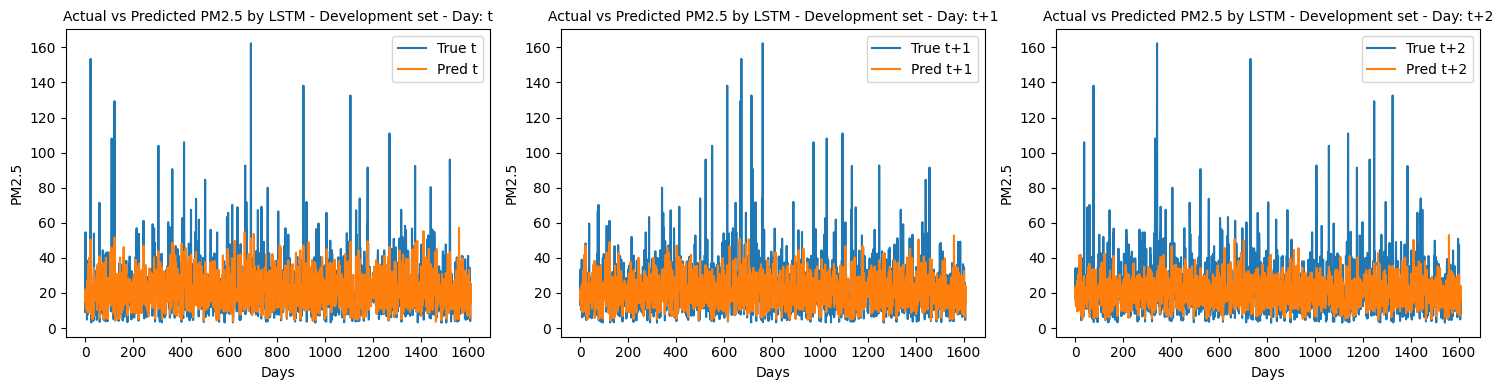

In [36]:
# dev set
test_metrics, y_true, y_pred = evaluate(model_final, loader_dev)
print("Test metrics:")
for k, v in test_metrics.items():
  print(f"{k}: {v}")
title = "Actual vs Predicted PM2.5 by LSTM - Development set - Day:"
plot_all_horizons(y_true, y_pred, title)

Test metrics:
t: {'RMSE': 14.084973335266113, 'MAE': 9.487759590148926, 'R2': 0.7262265183822199, 'Pearson r': 0.8548650741577148, 'IOA': 0.9098056703805923, 'NMB': -0.014573125168681145}
t+1: {'RMSE': 16.792760848999023, 'MAE': 11.282303810119629, 'R2': 0.6107646134706417, 'Pearson r': 0.7928112745285034, 'IOA': 0.8531462848186493, 'NMB': -0.06942533701658249}
t+2: {'RMSE': 18.501956939697266, 'MAE': 12.367161750793457, 'R2': 0.5284585461976035, 'Pearson r': 0.7466623783111572, 'IOA': 0.8076442033052444, 'NMB': -0.10717136412858963}


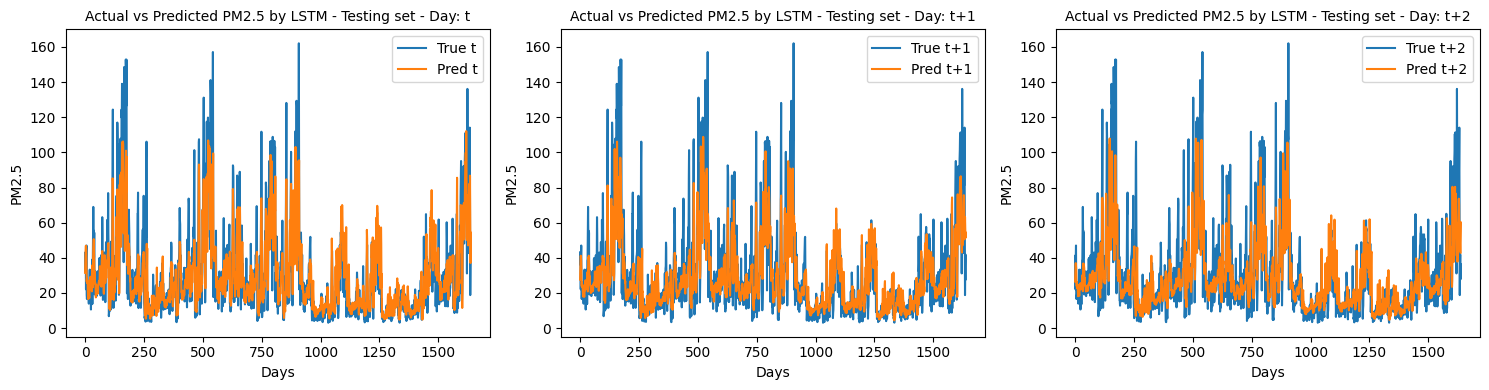

In [37]:
test_metrics, y_true, y_pred = evaluate(model_final, loader_test)
print("Test metrics:")
for k, v in test_metrics.items():
  print(f"{k}: {v}")
title = "Actual vs Predicted PM2.5 by LSTM - Testing set - Day:"
plot_all_horizons(y_true, y_pred, title)

t: {'RMSE': 14.084973335266113, 'MAE': 9.487759590148926, 'R2': 0.7262265183822199, 'Pearson r': 0.8548650741577148, 'IOA': 0.9098056703805923, 'NMB': -0.014573125168681145}
t+1: {'RMSE': 16.792760848999023, 'MAE': 11.282303810119629, 'R2': 0.6107646134706417, 'Pearson r': 0.7928112745285034, 'IOA': 0.8531462848186493, 'NMB': -0.06942533701658249}
t+2: {'RMSE': 18.501956939697266, 'MAE': 12.367161750793457, 'R2': 0.5284585461976035, 'Pearson r': 0.7466623783111572, 'IOA': 0.8076442033052444, 'NMB': -0.10717136412858963}


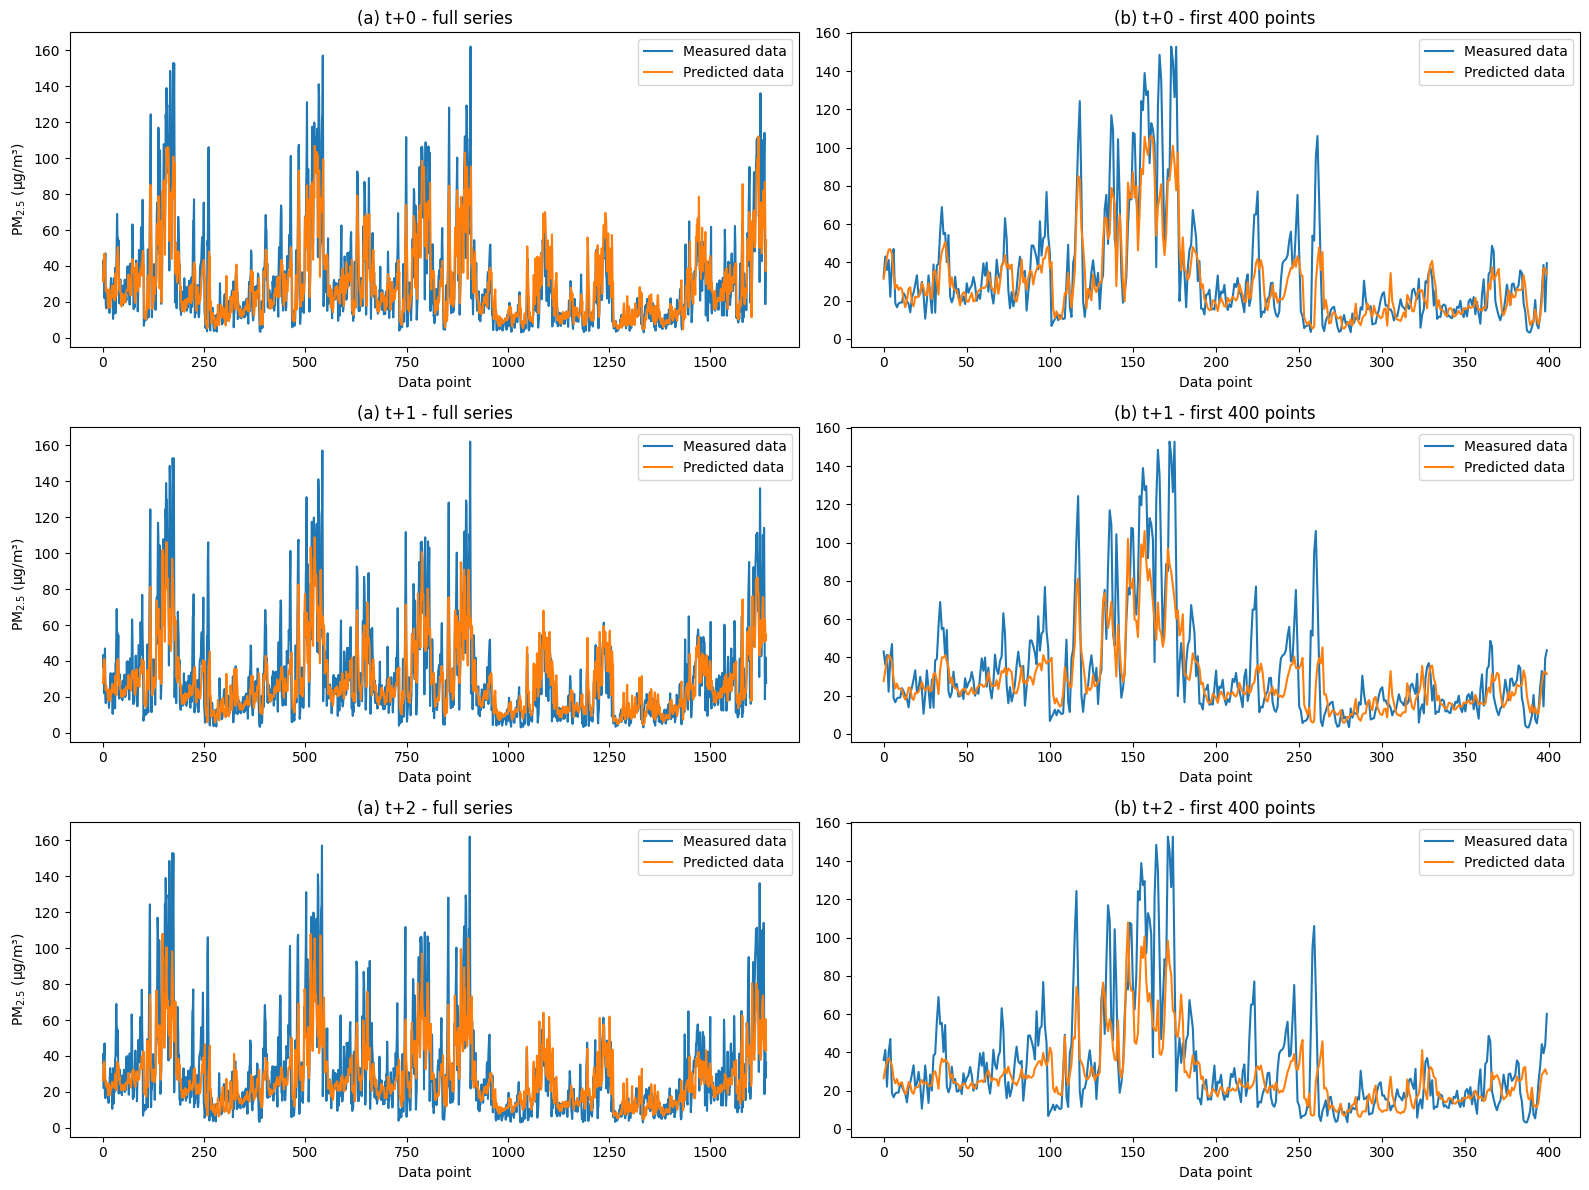

In [38]:
# test set
test_metrics, y_true, y_pred = evaluate(model_final, loader_test)
for k, v in test_metrics.items():
  print(f"{k}: {v}")

y_true_inv = np.expm1(scaler_y.inverse_transform(y_true))
y_pred_inv = np.expm1(scaler_y.inverse_transform(y_pred))

output_steps = y_true.shape[1]
num_points = y_true.shape[0]

fig, axs = plt.subplots(output_steps, 2, figsize=(16, 12))

for i in range(output_steps):
    axs[i, 0].plot(y_true_inv[:, i], label='Measured data')
    axs[i, 0].plot(y_pred_inv[:, i], label='Predicted data')
    axs[i, 0].set_title(f'(a) t+{i} - full series')
    axs[i, 0].set_ylabel('PM$_{2.5}$ (µg/m³)')
    axs[i, 0].set_xlabel('Data point')
    axs[i, 0].legend()

    axs[i, 1].plot(y_true_inv[:400, i], label='Measured data')
    axs[i, 1].plot(y_pred_inv[:400, i], label='Predicted data')
    axs[i, 1].set_title(f'(b) t+{i} - first 400 points')
    axs[i, 1].set_xlabel('Data point')
    axs[i, 1].legend()

plt.tight_layout()
plt.show()